# Replication notebook - PUMS figures

Sam Maurer, December 2017, Python 3.6

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import zipfile

## Load ACS PUMS data

2013, 1-year persons and households tables for California:  
http://www2.census.gov/acs2013_1yr/pums/csv_pca.zip  
http://www2.census.gov/acs2013_1yr/pums/csv_hca.zip

In [3]:
# Load PUMS households table
z = zipfile.ZipFile('/Users/smmaurer/Dropbox/Data/ACS PUMS/csv_hca.zip')
pums = pd.read_csv(z.open('ss13hca.csv'), low_memory=False)

In [4]:
print(len(pums))

153589


In [5]:
# Limit to Bay Area counties

pums = pums.loc[(pums.PUMA//100).isin([1,13,41,55,75,81,85,95,97])]
print(len(pums))

31068


In [7]:
# Load persons table
z = zipfile.ZipFile('/Users/smmaurer/Dropbox/Data/ACS PUMS/csv_pca.zip')
persons = pd.read_csv(z.open('ss13pca.csv'), low_memory=False)

In [8]:
print(len(persons))

371403


In [9]:
# Keep householders and relevant colums
persons = persons.loc[persons.RELP.isin([0]), ['SERIALNO','AGEP']]
print(len(persons))

130145


In [10]:
# Merged with other table
pums = pd.merge(pums, persons, how='left', on='SERIALNO')
print(len(pums))

31068


In [11]:
# TEN = Tenure
# 1 - owned with mortgage loan
# 2 - owned free and clear
# 3 - rented
# 4 - occupied without payment of rent

print(pums.TEN.value_counts())

1.0    11974
3.0    10168
2.0     4847
4.0      351
Name: TEN, dtype: int64


In [12]:
# MV = When moved into this house or apartment
# 1 - 12 months or less

print(pums.MV.value_counts())

5.0    5627
3.0    5182
4.0    4560
7.0    3529
1.0    3392
6.0    3199
2.0    1851
Name: MV, dtype: int64


In [13]:
print(len(pums.loc[pums.MV.isin([1]) & pums.TEN.isin([3])]))  # recent movers who rent
print(len(pums.loc[pums.MV.isin([1]) & pums.TEN.isin([1,2])]))  # recent movers who own

2489
861


## Bar plot of rents by county

In [16]:
pums['rent'] = pums.RNTP
pums['CFIPS'] = pums.PUMA // 100  # 3 digits of county FIPS, 2 digits of PUMA id

print(pums.loc[:,['rent','CFIPS']].head())

    rent  CFIPS
0    NaN     85
1  770.0      1
2    NaN     85
3    NaN     55
4  750.0     13


In [17]:
pums.CFIPS.value_counts()

85    7348
1     6949
13    4019
75    3739
81    3031
97    2203
95    1809
41    1179
55     791
Name: CFIPS, dtype: int64

In [18]:
movers = pums.loc[pums.moved == 1]
movers_rent = movers.groupby('CFIPS').median().rent
print(movers_rent)

CFIPS
1     1400.0
13    1300.0
41    1600.0
55    1700.0
75    2000.0
81    1800.0
85    1700.0
95    1200.0
97    1300.0
Name: rent, dtype: float64


In [19]:
non_movers = pums.loc[pums.moved == 0]
non_movers_rent = non_movers.groupby('CFIPS').median().rent
print(non_movers_rent)

CFIPS
1     1200.0
13    1300.0
41    1500.0
55    1200.0
75    1400.0
81    1500.0
85    1500.0
95    1100.0
97    1200.0
Name: rent, dtype: float64


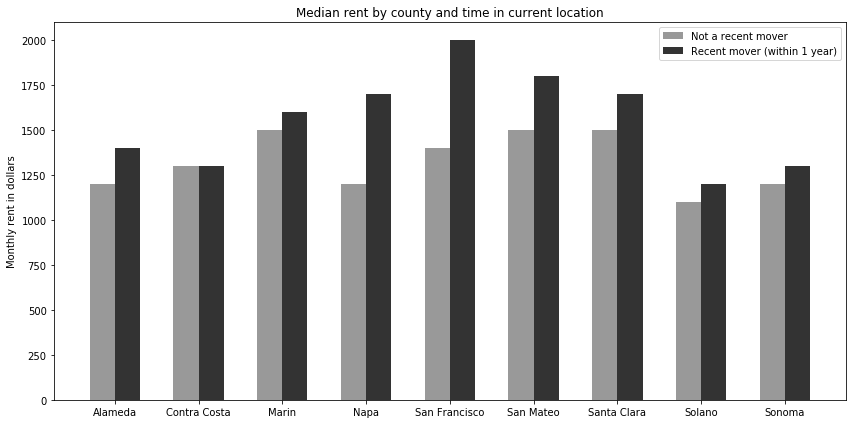

In [20]:
n = 9
ind = np.arange(n)
width = 0.3

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(ind, non_movers_rent, width, color=(0.6, 0.6, 0.6))
rects2 = ax.bar(ind+width, movers_rent, width, color=(0.2, 0.2, 0.2))

ax.set_ylabel('Monthly rent in dollars')
ax.set_title('Median rent by county and time in current location')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Alameda', 'Contra Costa', 'Marin', 'Napa', 'San Francisco', 'San Mateo',
                    'Santa Clara', 'Solano', 'Sonoma'))

ax.legend((rects1[0], rects2[0]), ('Not a recent mover', 'Recent mover (within 1 year)'))
plt.tight_layout()
plt.show()

In [21]:
fig.savefig('../output/figure-2.pdf')

## Rent burden

In [22]:
pums['rent'] = pums.RNTP
pums['income'] = pums.HINCP
pums['moved'] = pums.MV.isin([1]).astype(int)

In [23]:
pums.loc[pums.income > 0, 'rent_burden'] = (pums.rent * 12) / pums.income

In [24]:
movers = pums.loc[(pums.rent > 0) & (pums.moved == 1)]
non_movers = pums.loc[(pums.rent > 0) & (pums.moved == 0)]

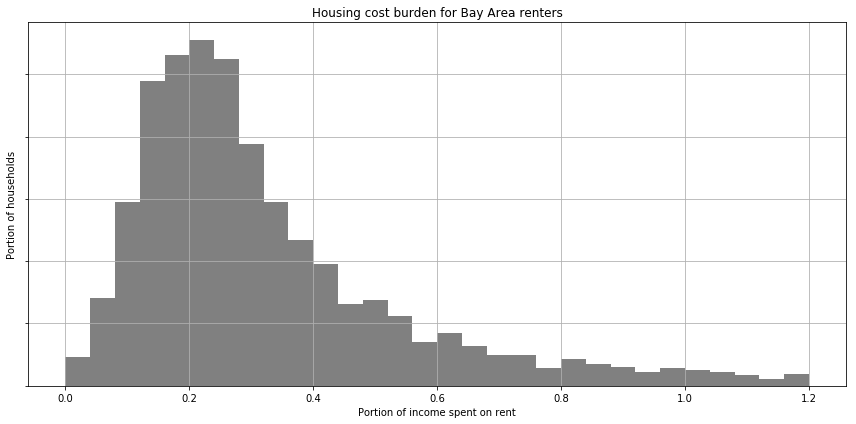

In [25]:
fig, ax = plt.subplots(figsize=(12,6))

pums.rent_burden.hist(range=(0,1.2), bins=30, color='grey')

plt.title('Housing cost burden for Bay Area renters')
ax.set_xlabel('Portion of income spent on rent')
ax.set_ylabel('Portion of households')
ax.set_yticklabels('')

plt.tight_layout()
plt.show()

In [26]:
fig.savefig('../output/figure-4.pdf')